In [40]:
%matplotlib inline
%run analyze_traj.py



 WELCOME TO TRACK_ANALYSIS 
 Developped and maintained by Arthur Michaut: arthur.michaut@gmail.com 
 Released on 10-14-2017


     _''_
    / o  \
  <       |
    \    /__
    /       \-----
    /    \    \   \__
    |     \_____\  __>
     \--       ___/  
        \     /
         || ||
         /\ /\


Usage: 
- plot cells analysis using cell_analysis(data_dir,refresh,parallelize,plot_traj,hide_labels,no_bkg,linewidth) 	 data_dir: data directory, refresh (default False) to refresh the table values, parallelize (default False) to run analyses in parallel, 
plot_traj (default true) to print the cell trajectories, hide_labels (default True) to hide the cell label, no_bkg (default False) to remove the image background, linewidth being the trajectories width (default=1.0) 

- plot maps using map_analysis(data_dir,refresh,parallelize,x_grid_size,no_bkg,z0,dimensions,axis_on) 	 data_dir: data directory, refresh (default False) to refresh the table values, parallelize (default False) to ru

In [4]:
#### GENERATE SYNTHETIC DATA

def make_diff_traj(part_index=0,grid_size=[500,500,500],dim=3,tmax=500,periodic=True,noise_amp=10,x0=[250,250,250],bias=[0,0,0]):
    #time and index
    t = arange(tmax)
    index = ones(tmax)*part_index
    #displacement
    displacement=np.random.randn(tmax,dim)*noise_amp
    for i in range(dim):
        displacement[:,i]+=ones(tmax)*bias[i]
    #traj
    traj=np.zeros((tmax,dim))
    for i in range(dim):
        traj[:,i]=np.cumsum(displacement[:,i])+x0[i]
        if periodic:
            traj[:,i]=np.remainder(traj[:,i],grid_size[i])
    
    return pd.DataFrame(np.concatenate([index[:,None],index[:,None],t[:,None],traj,zeros((tmax,6))],axis=1),columns=['i','traj','frame']+list('xyz')[0:dim]+['m0','m1','m2','m3','m4','NPscore'])
    

# #random diffusion
# part_num=30
# noise_amp=10
# grid_size=[500,500,500]
# bias=[0,0,0]
# tmax=50
# df=pd.DataFrame([],columns=['i','traj','frame','x','y','z','m0','m1','m2','m3','m4','NPscore'])
# for i in range(part_num):
#     x0=[np.random.uniform(0,grid_size[i]) for i in range(dim)]
#     traj=make_diff_traj(part_index=i,noise_amp=noise_amp,x0=x0,bias=bias,tmax=tmax)
#     df=pd.concat([df,traj])
    
# savetxt(osp.join(outdir,'test_data.txt'),a,delimiter='\t')

# #converging
# outdir='/home/amichaut/Desktop/charlene/data/synthetic_data/converging'
# if osp.exists(outdir) is False:
#     os.mkdir(outdir)

# part_num=200
# noise_amp=10
# grid_size=[500,500,500]
# tmax=20
# periodic=False
# df=pd.DataFrame([],columns=['i','traj','frame','x','y','z','m0','m1','m2','m3','m4','NPscore'])
# for i in range(part_num/2):
#     x0=[np.random.uniform(0,grid_size[0]/5),np.random.uniform(0,grid_size[1]),np.random.uniform(0,grid_size[2])]
#     traj=make_diff_traj(part_index=i,noise_amp=noise_amp,x0=x0,bias=[10,0,0],tmax=tmax,periodic=periodic)
#     df=pd.concat([df,traj])
# for i in range(part_num/2,part_num):
#     x0=[np.random.uniform(grid_size[0]*4/5,grid_size[0]),np.random.uniform(0,grid_size[1]),np.random.uniform(0,grid_size[2])]
#     traj=make_diff_traj(part_index=i,noise_amp=noise_amp,x0=x0,bias=[-10,0,0],tmax=tmax,periodic=periodic)
#     df=pd.concat([df,traj])
    
# #straight
# outdir='/home/amichaut/Desktop/charlene/data/synthetic_data/straight'
# if osp.exists(outdir) is False:
#     os.mkdir(outdir)

# part_num=20
# noise_amp=0
# grid_size=[500,500,500]
# tmax=20
# periodic=False
# df=pd.DataFrame([],columns=['i','traj','frame','x','y','z','m0','m1','m2','m3','m4','NPscore'])
# for i in range(part_num):
#     x0=[np.random.uniform(0,grid_size[0]/5),np.random.uniform(0,grid_size[1]),np.random.uniform(0,grid_size[2])]
#     traj=make_diff_traj(part_index=i,noise_amp=noise_amp,x0=x0,bias=[10,0,0],tmax=tmax,periodic=periodic)
#     df=pd.concat([df,traj])
    
# savetxt(osp.join(outdir,'table.txt'),df.values,delimiter='\t')

#straight
outdir='/home/amichaut/Desktop/charlene/data/synthetic_data/gradient'
if osp.exists(outdir) is False:
    os.mkdir(outdir)

part_num=100
noise_amp=5
grid_size=[500,500,500]
tmax=40
periodic=False
df=pd.DataFrame([],columns=['i','traj','frame','x','y','z','m0','m1','m2','m3','m4','NPscore'])
gradient_step_num=10
for k in range(gradient_step_num):
    for i in range(k*part_num/gradient_step_num,(k+1)*part_num/gradient_step_num):
        x0=[np.random.uniform(0,grid_size[0]/5),np.random.uniform(k*grid_size[1]/gradient_step_num,(k+1)*grid_size[1]/gradient_step_num),np.random.uniform(0,grid_size[2])]
        traj=make_diff_traj(part_index=i,noise_amp=noise_amp,x0=x0,bias=[k,0,0],tmax=tmax,periodic=periodic)
        df=pd.concat([df,traj])
    
savetxt(osp.join(outdir,'table.txt'),df.values,delimiter='\t')

/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


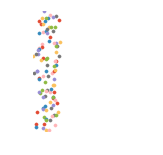

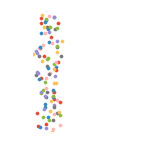

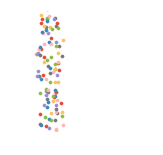

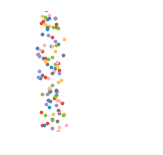

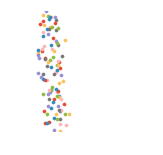

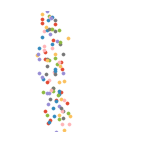

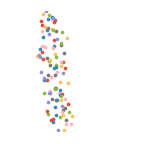

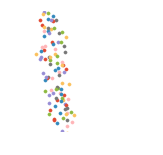

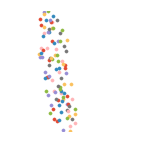

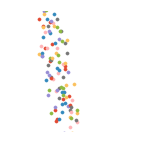

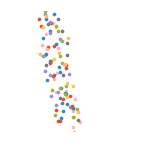

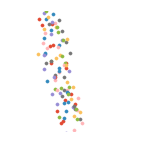

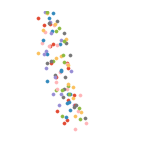

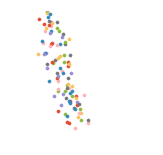

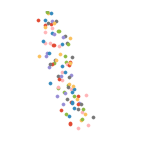

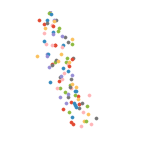

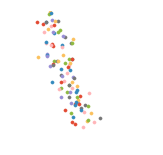

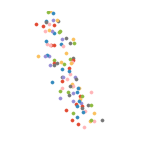

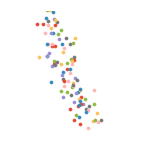

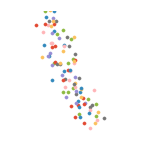

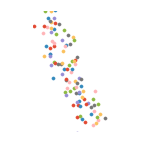

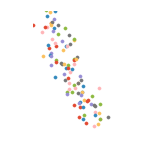

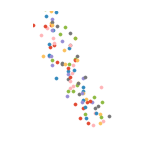

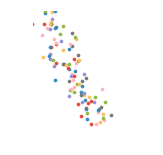

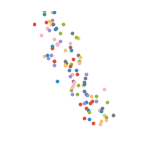

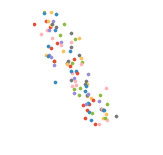

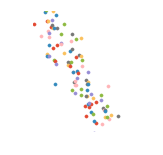

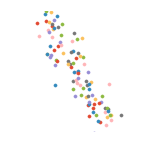

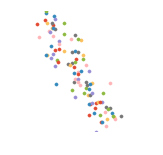

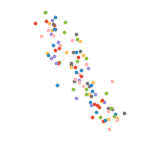

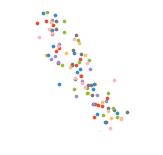

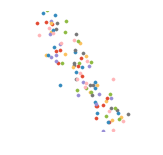

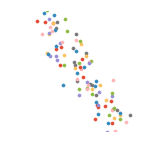

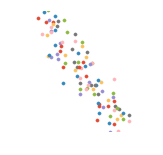

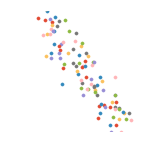

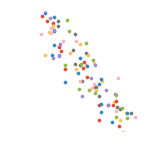

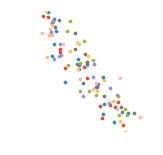

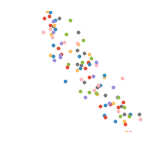

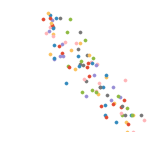

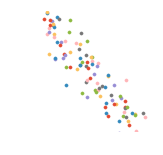

In [5]:
# plot synthetic data
outplot=osp.join(outdir,'raw')
if osp.exists(outplot) is False:
    os.mkdir(outplot)
    
groups=df.groupby('frame')
for i in range(tmax):
    group=groups.get_group(i).reset_index(drop=True)
    fig=figure(frameon=False)
    fig.set_size_inches(500/300.,500/300.)
    ax = fig.add_axes([0, 0, 1, 1])
    for k in range(group.shape[0]):
        ax.scatter(group.loc[k,'x'],group.loc[k,'y'],s=10)
    xlim(0,500)
    ylim(500,0)
    ax.axis('off')
    fig.savefig(osp.join(outplot,'%04d.png'%i),dpi=300)


In [41]:
data=XY_flow('/home/amichaut/Desktop/charlene/data/synthetic_data/gradient',window_size=40,selection_frame=0,frame_subset=[0,39])

Draw two lines (and press ENTER to validate each one of them). 
 The first defines your vertical surface (the first point will be the origin of the plot). The second needs to be approximatively perpendicular to the first one. It gives the orientation to the flow (going from the first point to the 2nd)
Draw your selections, press ENTER to validate one and close the window when you are finished
You have selected 2 ROIs
Is the selection correct? [y]/n: 
computing XY flow 39                                      

/usr/local/lib/python2.7/dist-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


In [8]:
df=pd.DataFrame(np.zeros((4,2)),columns=['a','b'])

In [22]:
x=data[22]['x_data']
y=data[22]['y_data']

In [24]:
a=array([x,y]).T

In [26]:
df=pd.DataFrame(a,columns=list('xy'))

In [37]:
df2=df.copy()
df2['y']=df['y'].rolling(50).mean()
df2

,x,y
0,0.0,NaN
1,1.0,NaN
2,2.0,NaN
3,3.0,NaN
4,4.0,NaN
5,5.0,NaN
6,6.0,NaN
7,7.0,NaN
8,8.0,NaN
9,9.0,NaN


Draw your selections, press ENTER to validate one and close the window when you are finished
You have selected 2 ROIs
Is the selection correct? [y]/n: 
before (100, 20)
remove nan (100, 24)
types displm prev, denom, intersec,A,B,C float64 float64 float64 float64 <type 'numpy.int64'> <type 'numpy.int64'> <type 'numpy.int64'>
all intercepts


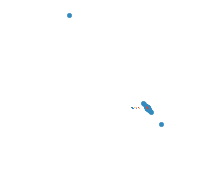

keep on line (49, 27)
on line intercepts


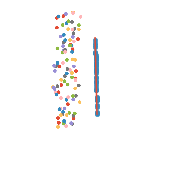

all I-x


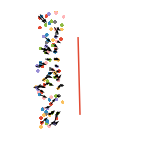

converging I-x


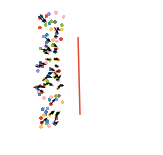

keep crossing (0, 31)
data []


In [42]:
data_dir=outdir
df,lengthscale,timescale,columns,dim=get_data(data_dir)
frame=2
image_dir=osp.join(data_dir,'raw')
line,orientation=get_ROI(image_dir,0,tool=LineTool) #lines coordinates are given 2nd point first and 1st point second
line=line[::-1,:]; orientation=orientation[::-1,:]
groups=df.groupby('frame');window_size=None;z_depth=None;reg_data_bin=1.;plot_steps=True
group=groups.get_group(frame).reset_index(drop=True)
print 'before',group.shape

#find intersection (beware vx is in um and coordinates in px) using formula from https://en.wikipedia.org/wiki/Line%E2%80%93line_intersection
x1=line[0][0];y1=line[0][1];x2=line[1][0];y2=line[1][1]
Ox1=orientation[0][0];Oy1=orientation[0][1];Ox2=orientation[1][0];Oy2=orientation[1][1]

for dim in ['x','y']:
    group['displ_'+dim]=group['v'+dim]*timescale*lengthscale 
    group[dim+'_prev']=group[dim]-group['displ_'+dim] #get previous timestep position
group = group[(np.isfinite(group['x_prev'])|np.isfinite(group['y_prev']))] #remove nan
print 'remove nan',group.shape

#calculate coordinates of point (I) of intersection between line and displacement vector
A=x1*y2-y1*x2; B=x1-x2; C=y1-y2
group['intersec_denom']=B*group['displ_y'] - C*group['displ_x']
group['intersec_x']=(A*group['displ_x']-B*(group['x']*group['y_prev']-group['y']*group['x_prev']))/group['intersec_denom']#intesection x_coord
group['intersec_y']=(A*group['displ_y']-C*(group['x']*group['y_prev']-group['y']*group['x_prev']))/group['intersec_denom']#intesection y_coord
print "types displm prev, denom, intersec,A,B,C",group['displ_x'].dtype, group['x_prev'].dtype, group['intersec_denom'].dtype, group['intersec_x'].dtype, type(A),type(B),type(C)
if plot_steps:
    print "all intercepts"
    fig,ax,xmin,ymin,xmax,ymax=get_background(df,data_dir,frame)
    group.plot.scatter(x='intersec_x',y='intersec_y',ax=ax)
    ax.plot([x1,x2],[y1,y2])
    show(fig)


# #check if I on line
ind=((group['intersec_x']>=min(x1,x2)) & (group['intersec_x']<=max(x1,x2)) & (group['intersec_y']>=min(y1,y2))&(group['intersec_y']<=max(y1,y2)))
group=group[ind]
print 'keep on line',group.shape
if plot_steps:
    print "on line intercepts"
    fig,ax,xmin,ymin,xmax,ymax=get_background(df,data_dir,frame)
    group.plot.scatter(x='intersec_x',y='intersec_y',ax=ax)
    ax.plot([x1,x2],[y1,y2])
    show(fig)

#check if crossing line 
group['intersec_vecx']=group['intersec_x']-group['x_prev']#vector I-x between intersection and previous point
group['intersec_vecy']=group['intersec_y']-group['y_prev']
group['converging']=group['intersec_vecx']*group['displ_x']+group['intersec_vecy']*group['displ_y'] #scalar product between (I-x) and displacement vectors.
if plot_steps:
    print "all I-x"
    fig,ax,xmin,ymin,xmax,ymax=get_background(df,data_dir,frame)
    ax.quiver(group['x_prev'].values,group['y_prev'].values,group['intersec_vecx'].values,group['intersec_vecy'].values)
    ax.plot([x1,x2],[y1,y2])
    show(fig)

group=group[group['converging']>0] #if >0 converging towards line. If not discard because crossing is impossible
if plot_steps:
    print "converging I-x"
    fig,ax,xmin,ymin,xmax,ymax=get_background(df,data_dir,frame)
    ax.quiver(group['x_prev'].values,group['y_prev'].values,group['intersec_vecx'].values,group['intersec_vecy'].values)
    ax.plot([x1,x2],[y1,y2])
    show(fig)

group['crossing']=(group['displ_x']**2+group['displ_y']**2)/(group['intersec_vecx']**2+group['intersec_vecy']**2) #|displ|^2/|I-x|^2
group=group[group['crossing']>=1] #if displacement > distance to surface
print 'keep crossing',group.shape

#compute orientation
group['orientation']=group['displ_x']*(Ox2-Ox1)+group['displ_y']*(Oy2-Oy1) #scalar product between O and displ
group['orientation']=group['orientation'].apply(lambda x:1 if x>0 else -1)

#compute distance to line end
group['line_abscissa']=np.sqrt((group['intersec_x']-x1)**2+(group['intersec_y']-y1)**2)

#return data
data=group[['line_abscissa','orientation']].values
print 'data', data


In [41]:
print line
group[['intersec_x','intersec_vecx','displ_x','x_prev','crossing']]

[[246  37]
 [250 298]]


,intersec_x,intersec_vecx,displ_x,x_prev,crossing
0,248.764780,216.608507,3.801839,32.156273,14.454112
3,247.699080,158.515677,3.287525,89.183404,10.807983
12,247.885904,149.645063,4.446057,98.240840,19.767653
19,247.974248,178.841448,10.992188,69.132800,120.829055
30,246.057614,230.381980,3.365729,15.675634,11.328187
31,248.413164,132.652573,3.859669,115.760592,14.897045
32,248.695309,247.027396,10.274244,1.667913,105.560124
35,249.716108,204.588495,1.777877,45.127613,3.160859
38,247.097413,224.150415,7.195654,22.946998,51.777559
40,247.232072,184.073227,9.475515,63.158845,89.785801


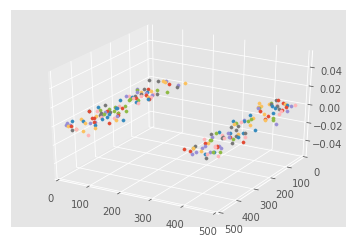

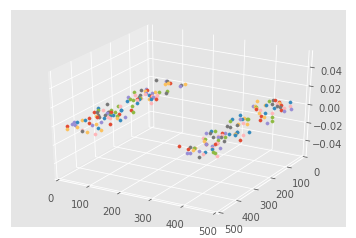

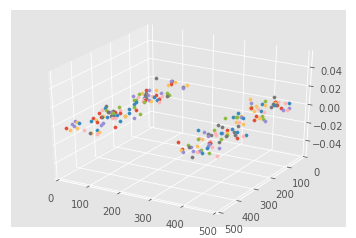

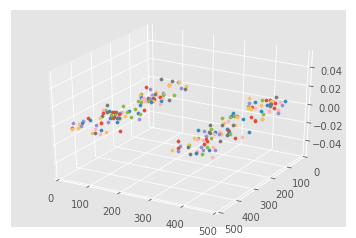

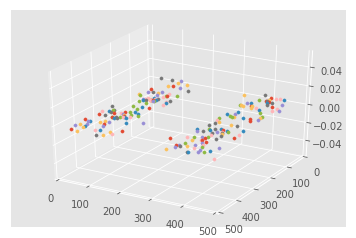

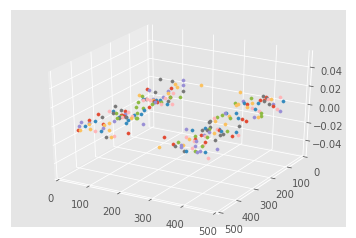

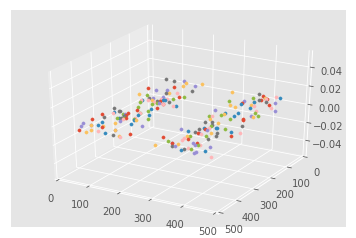

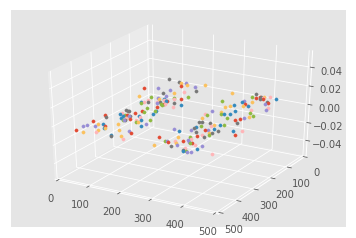

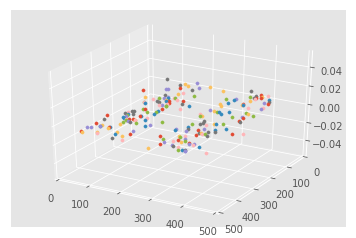

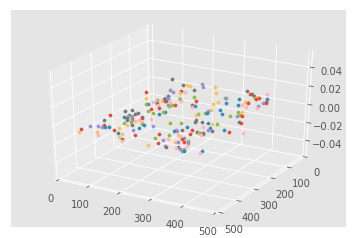

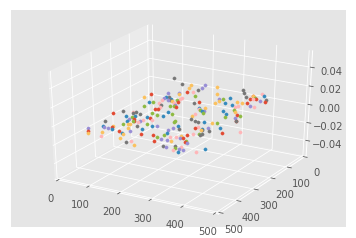

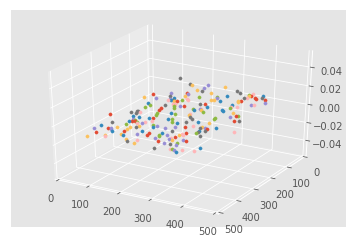

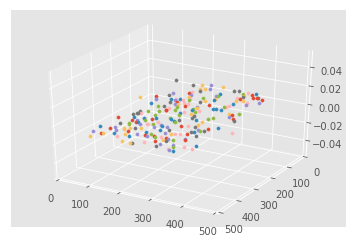

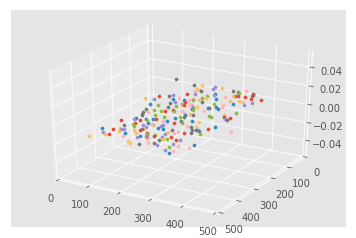

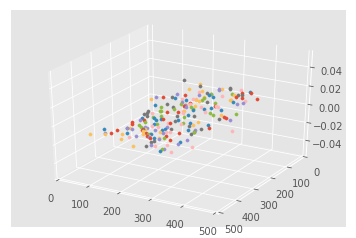

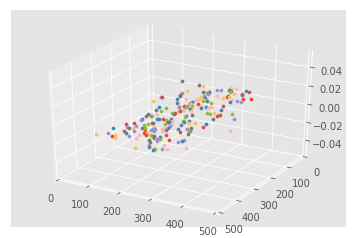

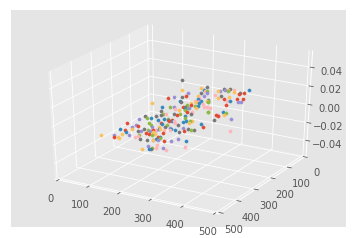

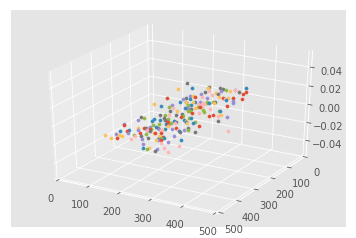

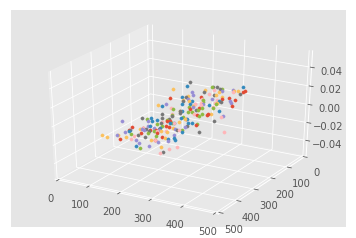

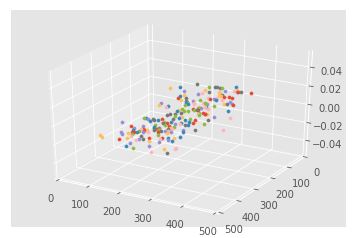

In [3]:
# plot synthetic 3D data
from mpl_toolkits.mplot3d import Axes3D
outplot=osp.join(outdir,'raw_3D')
if osp.exists(outplot) is False:
    os.mkdir(outplot)
    
groups=df.groupby('frame')
for i in range(tmax):
    group=groups.get_group(i).reset_index(drop=True)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for k in range(group.shape[0]):
        ax.scatter(group.loc[k,'x'],group.loc[k,'y'],s=10)
    xlim(0,500)
    ylim(500,0)
    fig.savefig(osp.join(outplot,'%04d.png'%i),dpi=300)


computing velocity field 2.0  

<string>:387: RuntimeWarning: All-NaN axis encountered
<string>:392: RuntimeWarning: All-NaN slice encountered


computing mean velocity field 19.0                                                                                          

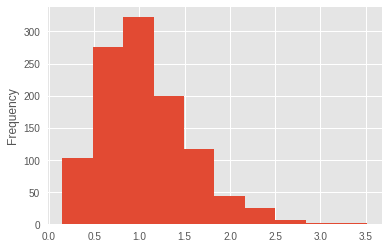

If you want to manually set the colorbar boundaries, enter the values (separated by a coma). Otherwise, press Enter: 
plotting mean velocity 19.0                   z0=-9.543484
plotting z flow 19.0ld 19.0                                      


In [98]:
map_analysis(outdir, refresh=True)

In [100]:
close('all')
avg_ROIs(outdir)

Give the map wou want to plot your ROIs on (div,mean_vel,z_flow,vfield): mean_vel
Give the frame number on which you want to draw your ROIs: 0
Draw your selections, press ENTER to validate one and close the window when you are finished
You have selected 1 ROIs
Is the selection correct? [y]/n: 
plotting ROI average 19.0                  


In [129]:
array(range(1,9))*9

array([ 9, 18, 27, 36, 45, 54, 63, 72])

[-1, 7, -1, 7]

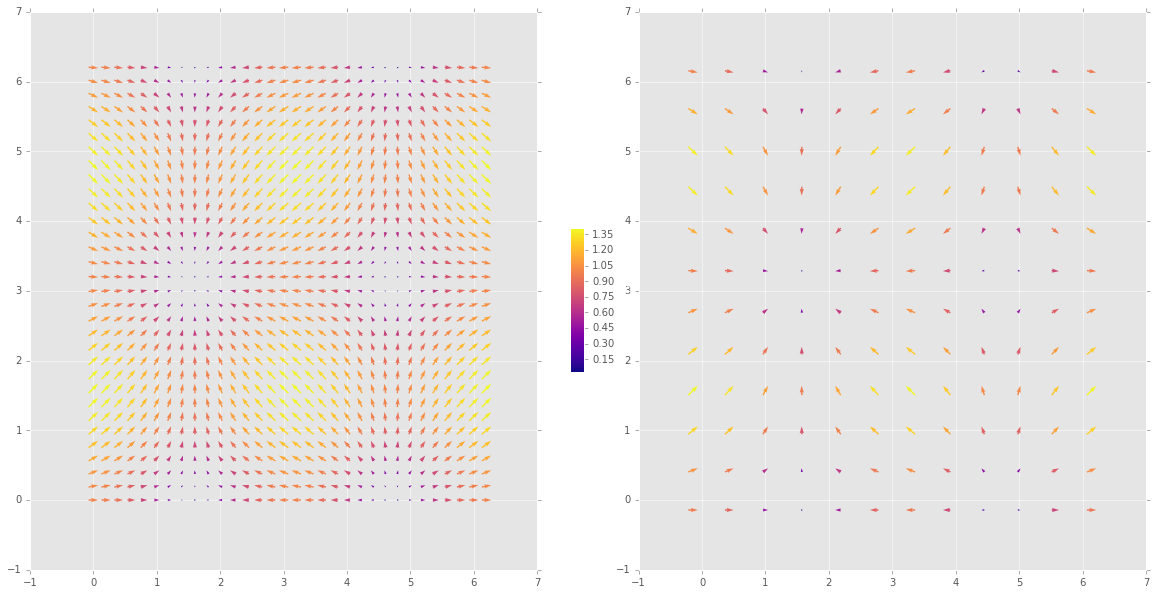

In [91]:
### TEST QUIVER

X, Y = np.meshgrid(np.arange(0, 2 * np.pi, .2), np.arange(0, 2 * np.pi, .2))
U = np.cos(X)
V = np.sin(Y)
fig, (ax, ax1) = plt.subplots(ncols=2, figsize=(20, 10))
M = np.hypot(U, V)
Q = ax.quiver(X, Y, U, V, M,
               units='x',
               pivot='mid',
               width=0.022,
               scale=1 / 0.15,
              cmap='plasma')

xmin, ymin, xmax, ymax=ax.axis()

cbaxes = fig.add_axes([0.5, 0.4, 0.01, 0.2]) 
cbar = fig.colorbar(Q,cax = cbaxes,label='$v_z\ (\mu m.min^{-1})$')
cbaxes.yaxis.label.set_color('white')
ax.axis([-1, 7, -1, 7])

### average grid

a=hstack([X.reshape(32*32,1),Y.reshape(32*32,1),U.reshape(32*32,1),V.reshape(32*32,1),M.reshape(32*32,1)])
df=pd.DataFrame(a,columns=['x','y','vx','vy','vz'])

#make subgrid
res=15
xmin, xmax, ymin, ymax = [-1, 7, -1, 7]
xsubgrid=linspace(xmin,xmax,res);ysubgrid=linspace(ymin,ymax,res)
X=[];Y=[];VX=[];VY=[];VZ=[] #new data
for i,xg in enumerate(xsubgrid[:-1]):
    for j,yg in enumerate(ysubgrid[:-1]):
        xg1=xsubgrid[i+1];yg1=ysubgrid[j+1]
        ind=((df['x']>=xg) & (df['x']<xg1) & (df['y']>=yg) & (df['y']<yg1))
        VX.append(df[ind]['vx'].mean());VY.append(df[ind]['vy'].mean());VZ.append(df[ind]['vz'].mean())
        X.append(xg+(xg1-xg)*0.5);Y.append(yg+(yg1-yg)*0.5) #center of the cell

Q = ax1.quiver(X,Y,VX,VY,VZ,
               units='x',
               pivot='mid',
               width=0.022,
               scale=1 / 0.15,
              cmap='plasma')

ax1.axis([-1, 7, -1, 7])

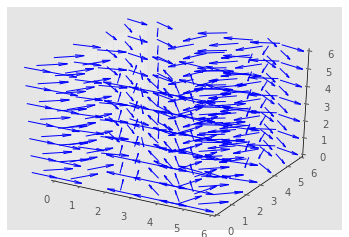

In [17]:
from mpl_toolkits.mplot3d import axes3d
fig = plt.figure()
ax = fig.gca(projection='3d')

step=1

x, y, z = np.meshgrid(np.arange(0, 2 * np.pi, step),
                      np.arange(0, 2 * np.pi, step),
                      np.arange(0, 2 * np.pi, step))

u = np.cos(x)
v = np.sin(y)
w = np.ones(x.shape)*(0)

ax.quiver(x, y, z, u, v, w, length=1)

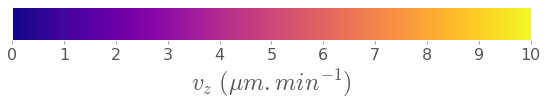

In [31]:
fig = figure(figsize=(8,3))
ax = fig.add_axes([0.05,0.80,0.9,0.15])
norm = plt.Normalize(vmin=0, vmax=10)
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cm.plasma,norm=norm,orientation='horizontal')
ax.tick_params(labelsize=16)
cb1.set_label(label='$v_z\ (\mu m.min^{-1})$',size=24)

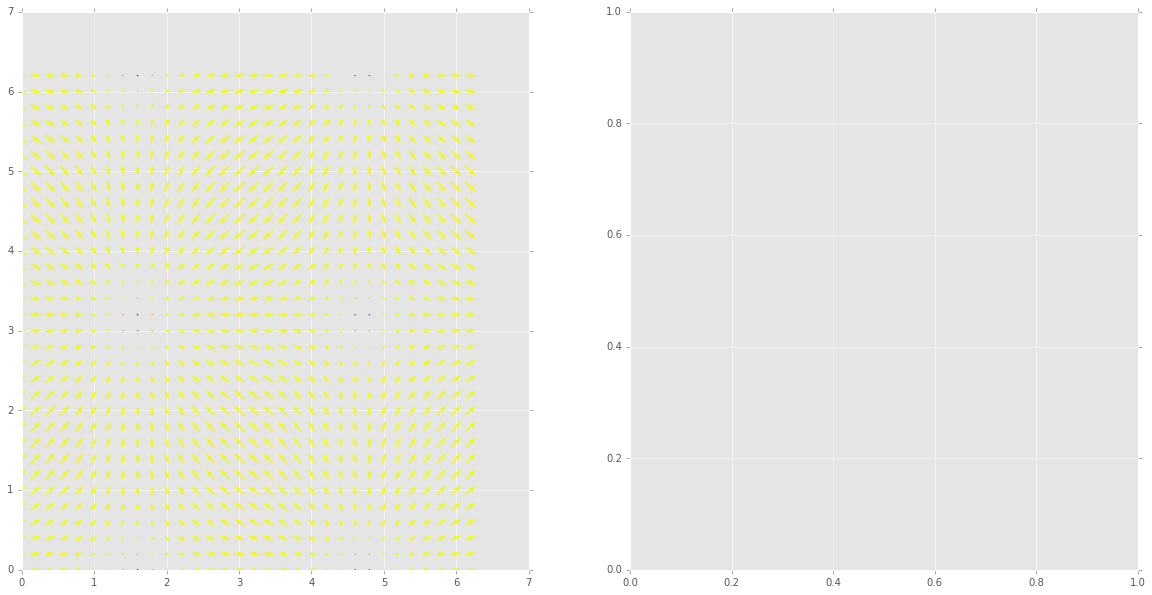

In [76]:
X, Y = np.meshgrid(np.arange(0, 2 * np.pi, .2), np.arange(0, 2 * np.pi, .2))
U = np.cos(X)
V = np.sin(Y)
fig, (ax, ax1) = plt.subplots(ncols=2, figsize=(20, 10))
M = np.hypot(U, V)
Q = ax.quiver(X, Y, U, V, M,
               units='x',
               pivot='mid',
               width=0.022,
               scale=1 / 0.15,
              cmap='plasma',
             norm=plt.Normalize(0,0.3))

In [1]:
%matplotlib inline
%run analyze_traj.py



 WELCOME TO TRACK_ANALYSIS 
 Developped and maintained by Arthur Michaut: arthur.michaut@gmail.com 
 Released on 09-15-2016


     _''_
    / o  \
  <       |
    \    /__
    /       \-----
    /    \    \   \__
    |     \_____\  __>
     \--       ___/  
        \     /
         || ||
         /\ /\


Usage: 
- plot cells analysis using cell_analysis(data_dir,refresh,parallelize,plot_traj,hide_labels,no_bkg,dimensions) 
 	 data_dir: data directory, refresh (default False) to refresh the table values, parallelize (default False) to run analyses in parallel, 
plot_traj (default true) to print the cell trajectories, hide_labels (default True) to hide the cell label, no_bkg (default False) to remove the image background, dimensions ([row,column] default None) to give the image dimension in case of no_bkg 

- plot maps using map_analysis(data_dir,refresh,parallelize,x_grid_size,no_bkg,z0,dimensions) 
 	 data_dir: data directory, refresh (default False) to refresh the table values, para

/usr/local/lib/python2.7/dist-packages/skimage/viewer/utils/core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "


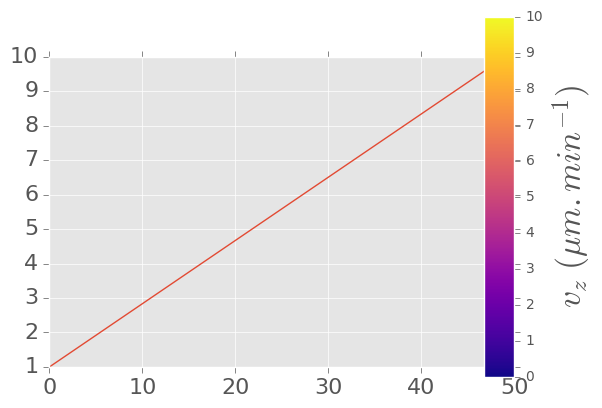

In [4]:
fig,ax=subplots(1,1)
ax.plot(linspace(1,10))
cax = fig.add_axes([0.85,0.10,0.05,0.9])
norm = plt.Normalize(vmin=0, vmax=10)
cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cm.plasma,norm=norm,orientation='vertical')
ax.tick_params(labelsize=16)
cb1.set_label(label='$v_z\ (\mu m.min^{-1})$',size=24)

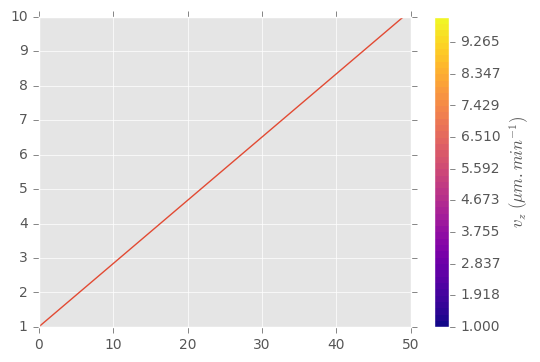

In [12]:
Z = [[0,0],[0,0]]
levels=linspace(1,10)
CS3 = plt.contourf(Z, levels, cmap=cm.plasma,label='$v_z\ (\mu m.min^{-1})$')
plt.clf()

fig,ax=subplots(1,1)
ax.plot(linspace(1,10))
cb1=fig.colorbar(CS3)
cb1.set_label(label='$v_z\ (\mu m.min^{-1})$')